Use z3

Code taken from @evansemet

In [1]:
import numpy as np
from z3 import *
from itertools import product, groupby
import matplotlib.pyplot as plt

In [2]:
board = np.array(
    [
        [0, 0, 0, 1, 1, 1, 3, 3, 5, 5, 5],
        [0, 2, 2, 2, 1, 1, 3, 5, 5, 5, 6],
        [0, 2, 2, 1, 1, 1, 3, 5, 5, 5, 6],
        [0, 2, 2, 1, 1, 4, 4, 5, 6, 6, 6],
        [0, 2, 1, 1, 5, 5, 4, 5, 6, 7, 6],
        [0, 5, 5, 5, 5, 5, 5, 5, 7, 7, 12],
        [8, 5, 5, 5, 5, 10, 10, 5, 7, 7, 7],
        [8, 8, 9, 5, 9, 10, 10, 5, 5, 7, 5],
        [8, 8, 9, 9, 9, 10, 10, 5, 5, 5, 5],
        [8, 9, 9, 8, 8, 8, 10, 5, 5, 5, 11],
        [8, 8, 8, 8, 8, 10, 10, 10, 5, 5, 11],
    ],
    dtype=int,
)


def generate_arrays() -> list[tuple]:
    def backtrack(arr, start, prev_neg_idx):
        if len(arr) == 11:
            if (
                arr.count(0) >= 2 * arr.count(-1)
                and arr[1] != -1
                and arr[-2] != -1
            ):
                results.append(tuple(arr[:]))
            return

        for val in [-1, 0]:
            if val == -1:
                if start < len(arr) - 1 and arr[start - 1] == -1:
                    continue
                if start > 0 and arr[start - 1] == -1:
                    continue
                if start < len(arr) - 2 and arr[start + 1] == -1:
                    continue
                if prev_neg_idx != -1 and start - prev_neg_idx < 3:
                    continue
                if start == 1 or start == len(arr) - 2:
                    continue
            arr.append(val)
            if val == -1:
                backtrack(arr, start + 1, start)
            else:
                backtrack(arr, start + 1, prev_neg_idx)
            arr.pop()

    results = list[tuple]()
    backtrack([], 0, -1)
    return results


all_row_arrangements = generate_arrays()
groups_of_zero = lambda tup: len(
    [list(g) for k, g in groupby(tup, lambda x: x == 0) if k]
)
row_arrangement_groups = dict[tuple, int](
    {tup: groups_of_zero(tup) for tup in all_row_arrangements}
)
row_arrangement_negatives = dict[tuple, int](
    {tup: tup.count(-1) for tup in all_row_arrangements}
)
index_groups_zero = lambda tup: list[tuple](
    [
        tuple(idx for idx, _ in group)
        for key, group in groupby(enumerate(tup), lambda x: x[1] == 0)
        if key
    ]
)
row_arrangement_zero_group_indicies = dict[tuple, list[tuple]](
    {tup: index_groups_zero(tup) for tup in all_row_arrangements}
)


def plot_model_with_annotations(model, X, N, row_labels, board):
    # Create a numpy array from the Z3 model
    arr = np.zeros((N, N), dtype=int)
    for i in range(N):
        for j in range(N):
            # Convert Z3 model evaluation to Python int
            arr[i, j] = model.eval(X[i, j]).as_long()

    total = 0
    for row in arr:
        groups = [
            "".join(str(x) for x in group)
            for key, group in groupby(row, lambda x: x == -1)
            if not key
        ]
        res = [int(group) for group in groups]
        print(res)
        total += sum(res)
    print(total)

    # Mapping unique board values to a colormap index
    unique_values = np.unique(board)  # Find unique values in the board
    color_map_index = {val: idx for idx, val in enumerate(unique_values)}

    # Generate colors for each unique value based on a colormap
    cmap = plt.get_cmap(
        "Spectral", len(unique_values)
    )  # Use 'viridis' colormap or any other suitable colormap
    # Normalize indices for color map
    norm = plt.Normalize(0, len(unique_values) - 1)
    color_array = cmap(
        norm([color_map_index[val] for val in board.ravel()])
    )  # Apply normalization before using cmap
    color_array = color_array.reshape(
        board.shape + (4,)
    )  # Ensure correct shape and 4 color channels (RGBA)

    # Create a mask for -1 values to color them black
    mask = arr == -1
    color_array[mask] = [0, 0, 0, 1]  # Set black color for -1 values

    # Plot the grid with colored cells
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(color_array, vmin=0, vmax=1)

    # Annotate each cell with the numeric value or empty string for -1
    for i in range(N):
        for j in range(N):
            label = "" if arr[i, j] == -1 else str(arr[i, j])
            ax.text(
                j,
                i,
                label,
                va="center",
                ha="center",
                color="white" if mask[i, j] else "black",
            )

    # Set row labels
    # ax.set_yticks(np.arange(N))
    # ax.set_yticklabels([''] + row_labels)  # Adjust labels list if needed

    # Remove column labels
    ax.set_xticks([])

    # Add grid lines for visibility
    ax.set_xticks(np.arange(-0.5, N, 1), minor=False)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=False)
    ax.grid(which="major", color="black", linestyle="-", linewidth=2)

    plt.grid(True)  # Enable grid
    plt.show()

In [3]:
orthagonal = lambda i, j, N: [
    (i + dx, j + dy)
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
    if 0 <= i + dx < N and 0 <= j + dy < N
]
diagonal = lambda i, j, N: [
    (i + dx, j + dy)
    for dx, dy in [(-1, -1), (-1, 1), (1, -1), (1, 1)]
    if 0 <= i + dx < N and 0 <= j + dy < N
]
all_neighbours = lambda i, j, N: orthagonal(i, j, N) + diagonal(i, j, N)


def is_perfect_square(expr):
    n = Int("n")
    return Exists(n, expr == n * n)

Done with constraints
[11122233444]
[13332, 3444]
[1331, 734449]
[133, 100411]
[13, 144, 4181]
[1444, 444889]
[74444, 74888]
[7714177, 989]
[77111779999]
[1144, 79992]
[444443, 3992]
88243711283


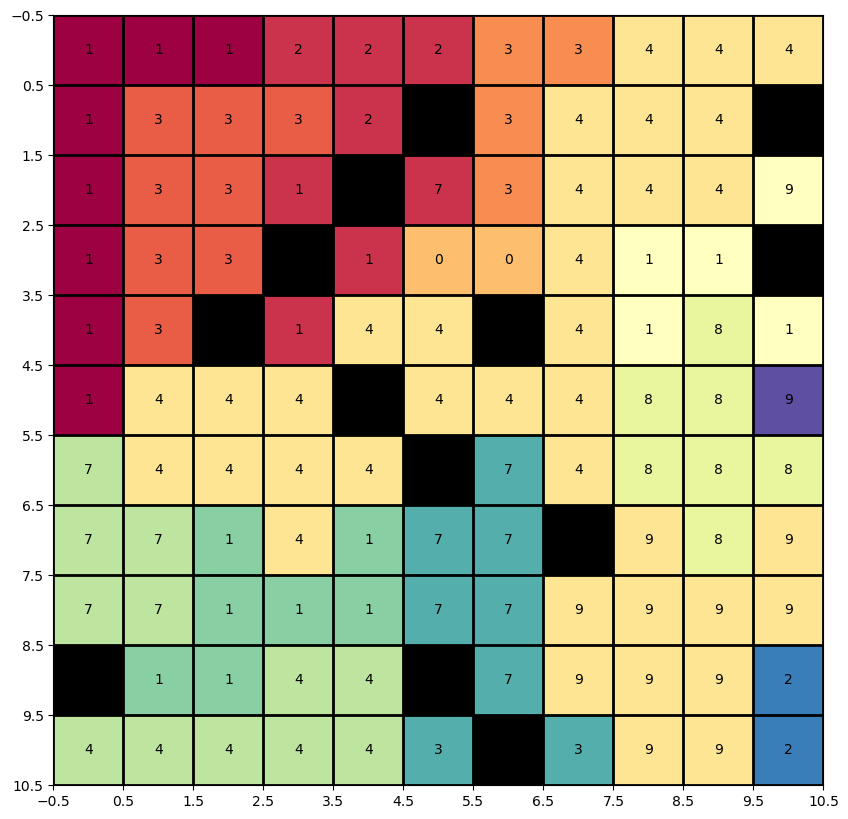

In [4]:
s = Solver()
N = len(board)
X = np.array(IntVector("x", N**2), dtype=object).reshape((N, N))


# general rules
# TODO
# all of the numbers are between -1 and 9 (-1 is how we represent the blocks)
s += [And(n >= -1, n <= 9) for n in X.ravel()]
# if in the same group and orthagonal either has to be the same number or one of them is a block
s += [
    (
        Or(X[i][j] == X[k][l], X[i][j] == -1, X[k][l] == -1)
        if board[k][l] == board[i][j]
        else Or(X[i][j] != X[k][l], X[i][j] == -1, X[k][l] == -1)
    )
    for i, j in product(range(N), repeat=2)
    for k, l in orthagonal(i, j, N)
]
# if in different groups and orthagonal then they have to be different numbers
s += [
    X[i][j] != X[k][l]
    for i, j in product(range(N), repeat=2)
    for k, l in orthagonal(i, j, N)
    if board[k][l] != board[i][j]
]
# blocks cannot touch each other
# FIXME
s += [
    Implies(X[i][j] == -1, X[k][l] != -1)
    for i, j in product(range(N), repeat=2)
    for k, l in orthagonal(i, j, N)
]
# the first number in each row cannot be a 0
s += [X[r][0] != 0 for r in range(N)]
# the second column cannot be a block otherwise not at least 2 digits and likewise the second to last
s += [And(X[r][1] != -1, X[r][-2] != -1) for r in range(N)]
# number to the right of a block cannot be a 0
s += [
    Implies(X[i][j] == -1, X[i][j + 1] != 0)
    for i, j in product(range(N), range(N - 1))
]
# a number cannot have a block to its left and right
s += [
    Implies(X[i][j - 1] == -1, X[i][j + 1] != -1)
    for i, j in product(range(N), range(1, N - 1))
]

# FIXME too slow
############################################################################################################
# square, row 0
# perfect squares can only end in 0, 1, 4, 5, 6, or 9
s += And(
    [
        Implies(
            X[0][c] == -1,
            Or(
                X[0][c - 1] == 0,
                X[0][c - 1] == 1,
                X[0][c - 1] == 4,
                X[0][c - 1] == 5,
                X[0][c - 1] == 6,
                X[0][c - 1] == 9,
            ),
        )
        for c in range(2, N)
    ]
)
s += Or(
    X[0][-1] == -1,
    Or(
        X[0][-1] == 0,
        X[0][-1] == 1,
        X[0][-1] == 4,
        X[0][-1] == 5,
        X[0][-1] == 6,
        X[0][-1] == 9,
    ),
)
# s += Or([And(And([If(val==0, X[0][c]>=0, X[0][c]==val) for c,val in enumerate(tup)]),
#              And([is_perfect_square(Sum([X[0][tup_idx]*10**(len(group)-idx-1) for idx,tup_idx in enumerate(group)]))
#                   for group in row_arrangement_zero_group_indicies[tup]]))
#          for tup in all_row_arrangements])
############################################################################################################


# 1 more than a palindrome, row 1
# # FIXME edge case with 9s
s += Or(
    [
        And(
            And(
                [
                    If(val == 0, X[1][c] >= 0, X[1][c] == val)
                    for c, val in enumerate(tup)
                ]
            ),
            And(
                [
                    And(
                        [
                            X[1][tup_idx] == X[1][group[::-1][idx]]
                            for idx, tup_idx in enumerate(group)
                            if 0 < idx < len(group) - 1
                        ]
                        + [X[1][group[-1]] == X[1][group[0]] + 1]
                    )
                    for group in row_arrangement_zero_group_indicies[tup]
                ]
            ),
        )
        for tup in all_row_arrangements
    ]
)

# prime raised to a prime power, row 2
# TODO

############################################################################################################
# sum of digits is 7, row 3
# full constraint
s += Or(
    [
        And(
            And(
                [
                    If(val == 0, X[3][c] >= 0, X[3][c] == val)
                    for c, val in enumerate(tup)
                ]
            ),
            And(
                [
                    Sum([X[3][tup_idx] for tup_idx in group]) == 7
                    for group in row_arrangement_zero_group_indicies[tup]
                ]
            ),
        )
        for tup in all_row_arrangements
    ]
)
############################################################################################################


# fibonacci, row 4
# TODO


# FIXME too slow
############################################################################################################
# square, row 5
s += Or(
    [
        And(
            And(
                [
                    If(val == 0, X[5][c] >= 0, X[5][c] == val)
                    for c, val in enumerate(tup)
                ]
            ),
            And(
                [
                    is_perfect_square(
                        Sum(
                            [
                                X[5][tup_idx] * 10 ** (len(group) - idx - 1)
                                for idx, tup_idx in enumerate(group)
                            ]
                        )
                    )
                    for group in row_arrangement_zero_group_indicies[tup]
                ]
            ),
        )
        for tup in all_row_arrangements
    ]
)
s += And(
    [
        Implies(
            X[5][c] == -1,
            Or(
                X[5][c - 1] == 0,
                X[5][c - 1] == 1,
                X[5][c - 1] == 4,
                X[5][c - 1] == 5,
                X[5][c - 1] == 6,
                X[5][c - 1] == 9,
            ),
        )
        for c in range(2, N)
    ]
)
s += Or(
    X[5][-1] == -1,
    Or(
        X[5][-1] == 0,
        X[5][-1] == 1,
        X[5][-1] == 4,
        X[5][-1] == 5,
        X[5][-1] == 6,
        X[5][-1] == 9,
    ),
)
############################################################################################################


############################################################################################################
# multiple of 37, row 6
s += Or(
    [
        And(
            And(
                [
                    If(val == 0, X[6][c] >= 0, X[6][c] == val)
                    for c, val in enumerate(tup)
                ]
            ),
            And(
                [
                    Sum(
                        [
                            X[6][tup_idx] * 10 ** (len(group) - idx - 1)
                            for idx, tup_idx in enumerate(group)
                        ]
                    )
                    % 37
                    == 0
                    for group in row_arrangement_zero_group_indicies[tup]
                ]
            ),
        )
        for tup in all_row_arrangements
    ]
)
############################################################################################################


############################################################################################################
# palindrome multiple of 23, row 7
# cannot have a palindrom multiple of 23 be 2 digits
s += [
    And(
        And([Implies(X[7][c] == -1, X[7][c + 3] != -1) for c in range(N - 3)]),
        X[7][-3] != -1,
    )
]
s += Or(
    [
        And(
            And(
                [
                    If(val == 0, X[7][c] >= 0, X[7][c] == val)
                    for c, val in enumerate(tup)
                ]
            ),
            And(
                [
                    Sum(
                        [
                            X[7][tup_idx] * 10 ** (len(group) - idx - 1)
                            for idx, tup_idx in enumerate(group)
                        ]
                    )
                    % 23
                    == 0
                    for group in row_arrangement_zero_group_indicies[tup]
                ]
            ),
            And(
                [
                    And(
                        [
                            X[7][tup_idx] == X[7][group[::-1][idx]]
                            for idx, tup_idx in enumerate(group)
                        ]
                    )
                    for group in row_arrangement_zero_group_indicies[tup]
                ]
            ),
        )
        for tup in all_row_arrangements
    ]
)
############################################################################################################

############################################################################################################
# product of digits ends in 1, row 8
# can only be blocks or 1, 3, 7, or 9
s += [
    Or(X[8][c] == -1, X[8][c] == 1, X[8][c] == 3, X[8][c] == 7, X[8][c] == 9)
    for c in range(N)
]
# full constraint
s += Or(
    [
        And(
            And(
                [
                    If(val == 0, X[8][c] >= 0, X[8][c] == val)
                    for c, val in enumerate(tup)
                ]
            ),
            And(
                [
                    Product([X[8][tup_idx] for tup_idx in group]) % 10 == 1
                    for group in row_arrangement_zero_group_indicies[tup]
                ]
            ),
        )
        for tup in all_row_arrangements
    ]
)
############################################################################################################

############################################################################################################
# multiple of 88, row 9
s += Or(
    [
        And(
            And(
                [
                    If(val == 0, X[9][c] >= 0, X[9][c] == val)
                    for c, val in enumerate(tup)
                ]
            ),
            And(
                [
                    Sum(
                        [
                            X[9][tup_idx] * 10 ** (len(group) - idx - 1)
                            for idx, tup_idx in enumerate(group)
                        ]
                    )
                    % 88
                    == 0
                    for group in row_arrangement_zero_group_indicies[tup]
                ]
            ),
        )
        for tup in all_row_arrangements
    ]
)
############################################################################################################

############################################################################################################
# 1 less than a palindrome, row 10
# we decided this has to be a block and the rest of the row befor this is a singular palindrom - 1
s += [
    And(
        X[-1][6] == -1,
        X[-1][5] == X[-1][4] - 1,
        And(
            Or(X[-1][0] == -1, X[-1][0] == X[-1][1]),
            X[-1][2] == X[-1][1],
            X[-1][3] == X[-1][1],
            X[-1][4] == X[-1][1],
        ),
    )
]
# how the last palindrome has to be
s += [
    Xor(
        And(X[-1][9] == X[-1][7] - 1, X[-1][-1] == -1),
        X[-1][-1] == X[-1][7] - 1,
    )
]
############################################################################################################


# TODO manual
# s.set("proof", True)
# s.set("proof.log", "proofs.log")
# solver.set("timeout", 5000)  # Timeout in milliseconds
s += And([X[r][-1] == 2 for r in [-1, -2]])
s += And(
    [X[5][r] == v for r, v in enumerate([1, 4, 4, 4, -1, 4, 4, 4, 8, 8, 9])]
)
s += And(
    [X[4][r] == v for r, v in enumerate([1, 3, -1, 1, 4, 4, -1, 4, 1, 8, 1])]
)
# s += And([X[2][r]==v for r,v in enumerate([None,3,3,1,-1,1,None,4,4,4,None]) if v is not None])

s += And(
    [X[1][c] == v for c, v in enumerate([1, 3, 3, 3, 2, -1, 3, 4, 4, 4, -1])]
)
s += And(
    [X[2][c] == v for c, v in enumerate([1, 3, 3, 1, -1, 7, 3, 4, 4, 4, 9])]
)
s += And([X[0][c] != -1 for c in range(N)])
# s += Implies(And(X[2][7]==4, X[2][8]==4, X[2][9]==4), Or([And(X[2][6]==a, X[2][-1]==b) for a,b in [(2,7),(3,3),(6,3),(6,7),(6,9),(7,3),(8,1),(8,7),(9,3)]]))

# s += Implies(And(X[4][4]==4, X[4][5]==4), And(X[4][2]==-1, X[4][3]==1, X[4][6]==-1))


print("Done with constraints")

if s.check() == sat:
    m = s.model()
    row_labels = [f"Row{i}" for i in range(1, N + 1)]
    plot_model_with_annotations(m, X, N, row_labels, board)

In [5]:
def sieve_of_eratosthenes(max_num):
    """Generate a list of primes up to max_num using the Sieve of Eratosthenes."""
    is_prime = [True] * (max_num + 1)
    is_prime[0], is_prime[1] = False, False  # 0 and 1 are not primes
    p = 2
    while p * p <= max_num:
        if is_prime[p]:
            for i in range(p * p, max_num + 1, p):
                is_prime[i] = False
        p += 1
    return [p for p in range(max_num + 1) if is_prime[p]]


def generate_primes_to_power_primes(limit):
    # Generate primes using the Sieve of Eratosthenes
    primes = sieve_of_eratosthenes(int(limit**0.5))

    result = set()
    for a in primes:
        power = a
        while power < limit:
            result.add(power)
            power *= a

    # Write the result to a file
    with open("result.txt", "w") as file:
        for power in sorted(result):
            file.write(str(power) + "\n")


# # Example usage
# generate_primes_to_power_primes(int(1e12))


def prime_powers_below_limit(limit):
    """List all numbers of the form p^q for prime p and q, where the result is below limit."""
    primes = sieve_of_eratosthenes(
        limit
    )  # We can limit the sieve to the square root of the limit for efficiency
    result = set()

    for p in primes:
        for q in primes:
            power = p**q
            if power < limit:
                result.add(power)
            else:
                break  # If p^q exceeds the limit, higher powers will also exceed it

    return sorted(result)


# # Set the limit
# limit = 10000000
# prime_powers = prime_powers_below_limit(limit)
# print(prime_powers)

In [6]:
# import math

# def check_same_digit_perfect_squares(x, max_num):
#     result = []
#     for num in range(1, max_num):
#         sqrt = int(math.sqrt(num))
#         if sqrt * sqrt == num:
#             num_str = str(num)
#             if len(num_str) < x: continue
#             if all(digit == num_str[0] for digit in num_str[:x]):
#                 result.append(num)
#     return result

# check_same_digit_perfect_squares(3, int(1e7))